In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("AER_credit_card_data.csv")

In [3]:
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [4]:
df.shape

(1319, 12)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   card         1319 non-null   object 
 1   reports      1319 non-null   int64  
 2   age          1319 non-null   float64
 3   income       1319 non-null   float64
 4   share        1319 non-null   float64
 5   expenditure  1319 non-null   float64
 6   owner        1319 non-null   object 
 7   selfemp      1319 non-null   object 
 8   dependents   1319 non-null   int64  
 9   months       1319 non-null   int64  
 10  majorcards   1319 non-null   int64  
 11  active       1319 non-null   int64  
dtypes: float64(4), int64(5), object(3)
memory usage: 123.8+ KB


### Preparation

In [6]:
# Create the target variable by mapping yes to 1 and no to 0.
df['card'] = np.where(df['card']=='yes',1,0)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   card         1319 non-null   int32  
 1   reports      1319 non-null   int64  
 2   age          1319 non-null   float64
 3   income       1319 non-null   float64
 4   share        1319 non-null   float64
 5   expenditure  1319 non-null   float64
 6   owner        1319 non-null   object 
 7   selfemp      1319 non-null   object 
 8   dependents   1319 non-null   int64  
 9   months       1319 non-null   int64  
 10  majorcards   1319 non-null   int64  
 11  active       1319 non-null   int64  
dtypes: float64(4), int32(1), int64(5), object(2)
memory usage: 118.6+ KB


In [8]:
# Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split funciton for that with random_state=1.
df_train,df_test = train_test_split(df,test_size = 0.2, random_state=1)
df_train,df_val  = train_test_split(df_train,test_size = 0.25, random_state=1)

In [9]:
df_train = df_train.reset_index(drop=True)
df_test  = df_test.reset_index(drop=True)
df_val   = df_val.reset_index(drop=True)

In [10]:
X_col = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]
y_col = "card"

In [11]:
#data preparation 

X_train = df_train[X_col] 
X_test  = df_test[X_col]
X_val   = df_val[X_col]

y_train = df_train[y_col] 
y_test  = df_test[y_col]
y_val   = df_val[y_col]

#### Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

- For each numerical variable, use it as score and compute AUC with the card variable.
- Use the training dataset for that.
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenditure']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?
- `reports`
- `dependents`
- `active`
- `share`

In [12]:
columns = ["reports",
"dependents",
"active",
"share"]

In [13]:
result = {}
for col in columns:
    print(col)
    auc = roc_auc_score(y_train,X_train[col])
    if auc<0.5:
        auc = roc_auc_score(y_train,-X_train[col]) 
    result[col]=auc

reports
dependents
active
share


In [14]:
result

{'reports': 0.7166629860689376,
 'dependents': 0.5327757227773791,
 'active': 0.6043173411362006,
 'share': 0.989183643423692}

__answer: option *d* `share`__

## Training the model
From now on, use these columns only:

`["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]`

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

`LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`

### Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.615
- 0.515
- 0.715
- 0.995

In [15]:
#data preparation
X_train = pd.get_dummies(X_train)
X_test  = pd.get_dummies(X_test)
X_val   = pd.get_dummies(X_val)

In [16]:
lr = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
lr.fit(X_train,y_train)
y_val_pred_proba =  lr.predict_proba(X_val)[:, 1]
score = roc_auc_score(y_val,y_val_pred_proba)
print("AUC Score: ", round(score,3))

AUC Score:  0.995


__answer: option *d* `0.995`__

### Question 3

Now let's compute precision and recall for our model.

- Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them


At which threshold precision and recall curves intersect?

- 0.1
- 0.3
- 0.6
- 0.8

In [17]:
def calculate_precision_recall(y_val, y_val_pred_proba):
    precision,recall = [],[]
    P,R = 0,0
    threshold = {}
    X = np.linspace(0, 1, 100)
    for i in range(len(X)):
        X[i] = round(X[i],2)

    for cut_off in X:
        y_pred_val = np.where(y_val_pred_proba<cut_off,0,1)
        M = confusion_matrix(y_val, y_pred_val)
        tn, fp, fn, tp = M.ravel() 
        P = round(tp/(tp+fp),3)
        R = round(tp/(tp+fn),3)
        precision.append(P)
        recall.append(R)
        threshold[cut_off] = {"precision":P,"recall":R}
    return threshold,precision,recall

In [18]:
threshold_dict,precision,recall = calculate_precision_recall(y_val, y_val_pred_proba)

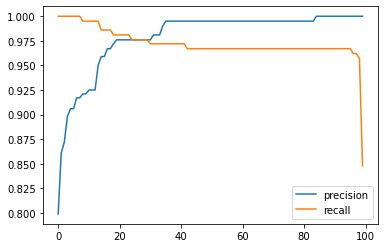

In [19]:
plt.plot(precision,label="precision")
plt.plot(recall,label="recall")
plt.legend()
plt.show()

In [20]:
for cutoff in threshold_dict:
    if threshold_dict[cutoff]['precision'] == threshold_dict[cutoff]['recall']:
        print(cutoff)

0.24
0.25
0.26
0.27
0.28
0.29


answer: __option *d* `0.30`__

### Question 4
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F1 = 2 * P * R / (P + R)

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.1
- 0.4
- 0.6
- 0.7

In [21]:
def calculate_f1(y_val, y_val_pred_proba):
    precision,recall = [],[]
    P,R = 0,0
    threshold = {}
    X = np.linspace(0, 1, 100)
    for i in range(len(X)):
        X[i] = round(X[i],2)

    for cut_off in X:
        y_pred_val = np.where(y_val_pred_proba<cut_off,0,1)
        M = confusion_matrix(y_val, y_pred_val)
        tn, fp, fn, tp = M.ravel() 
        P = round(tp/(tp+fp),5)
        R = round(tp/(tp+fn),5)
        f1 = (2*P*R)/(P+R)
        threshold[cut_off] = round(f1,5)
    return threshold

In [22]:
threshold = calculate_f1(y_val, y_val_pred_proba)

In [23]:
{k: v for k, v in sorted(threshold.items(), key=lambda item: item[1])}

{0.0: 0.88842,
 1.0: 0.91795,
 0.01: 0.92544,
 0.02: 0.93157,
 0.03: 0.94619,
 0.04: 0.95045,
 0.05: 0.95045,
 0.08: 0.95672,
 0.09: 0.95672,
 0.06: 0.95692,
 0.07: 0.95692,
 0.1: 0.9589,
 0.11: 0.9589,
 0.12: 0.9589,
 0.14: 0.97196,
 0.15: 0.97196,
 0.13: 0.97222,
 0.3: 0.97387,
 0.31: 0.97619,
 0.32: 0.97619,
 0.33: 0.97619,
 0.24: 0.9763,
 0.25: 0.9763,
 0.26: 0.9763,
 0.27: 0.9763,
 0.28: 0.9763,
 0.29: 0.9763,
 0.18: 0.97641,
 0.16: 0.97652,
 0.17: 0.97652,
 0.99: 0.97821,
 0.19: 0.97872,
 0.2: 0.97872,
 0.21: 0.97872,
 0.22: 0.97872,
 0.23: 0.97872,
 0.97: 0.98068,
 0.98: 0.98068,
 0.42: 0.98077,
 0.43: 0.98077,
 0.44: 0.98077,
 0.45: 0.98077,
 0.46: 0.98077,
 0.47: 0.98077,
 0.48: 0.98077,
 0.49: 0.98077,
 0.51: 0.98077,
 0.52: 0.98077,
 0.53: 0.98077,
 0.54: 0.98077,
 0.55: 0.98077,
 0.56: 0.98077,
 0.57: 0.98077,
 0.58: 0.98077,
 0.59: 0.98077,
 0.6: 0.98077,
 0.61: 0.98077,
 0.62: 0.98077,
 0.63: 0.98077,
 0.64: 0.98077,
 0.65: 0.98077,
 0.66: 0.98077,
 0.67: 0.98077,
 0.68: 

answer: __option *b* `0.41`__

#### Question 5

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

`KFold(n_splits=5, shuffle=True, random_state=1)`

- Iterate over different folds of df_full_train
- Split the data into train and validation
- Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
- Use AUC to evaluate the model on validation

How large is standard devidation of the AUC scores across different folds?

- 0.003
- 0.014
- 0.09
- 0.24

In [24]:
def get_k_fold_result(X,y):
    aucs = []
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    kf.get_n_splits(X)
    for train_index, val_index in kf.split(X):
        train_index, val_index = list(train_index),  list(val_index)
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        lr = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
        lr.fit(X_train,y_train)
        y_val_pred_proba =  lr.predict_proba(X_val)[:, 1]
        score = roc_auc_score(y_val,y_val_pred_proba)
        #print("AUC Score: ", round(score,3))
        aucs.append(round(score,3))
    return aucs

In [25]:
aucs = get_k_fold_result(X_train,y_train)
std_auc = round(np.std(aucs),3) 
print("AUC Score of 5-fold validation: ", std_auc)

AUC Score of 5-fold validation:  0.003


answer: __option *a* `0.003`__

### Question 6
Now let's use 5-Fold cross-validation to find the best parameter C

- Iterate over the following C values: `[0.01, 0.1, 1, 10]`
- Initialize `KFold` with the same parameters as previously
- Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

In [31]:
def get_k_fold_result(X,y):
    regularization_strength = [0.01, 0.1, 1, 10]
    auc_dict = {}
    
    for c in regularization_strength:
        aucs = []
        kf = KFold(n_splits=5, shuffle=True, random_state=1)
 
        for train_index, val_index in kf.split(X):
            train_index, val_index = list(train_index),  list(val_index)
            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

            lr = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
            lr.fit(X_train,y_train)
            y_val_pred_proba =  lr.predict_proba(X_val)[:, 1]
            score = roc_auc_score(y_val,y_val_pred_proba)
            aucs.append(round(score,3))
        print(aucs)
        mean_auc = round(np.mean(aucs),3) 
        std_auc  = round(np.std(aucs),3)
        auc_dict[c] = {"mean":mean_auc,"std":std_auc}
    return auc_dict

In [32]:
auc_dict = get_k_fold_result(X_train,y_train)

[0.984, 1.0, 0.989, 0.996, 0.991]
[0.989, 1.0, 0.991, 0.997, 0.997]
[0.996, 0.999, 0.991, 0.997, 1.0]
[0.997, 0.999, 0.989, 0.997, 1.0]


In [33]:
auc_dict

{0.01: {'mean': 0.992, 'std': 0.006},
 0.1: {'mean': 0.995, 'std': 0.004},
 1: {'mean': 0.997, 'std': 0.003},
 10: {'mean': 0.996, 'std': 0.004}}

answer: __option *d*__ `C=10` where mean = 0.995 and std = 0.005